In [34]:
#import necessary modules
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

In [35]:
#Set environment variables for py4jjava error
import os
import sys
os.environ['PYSPARK_PYTHON']= sys.executable
os.environ['PYSPARK_DRIVER_PYTHON']= sys.executable
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"

In [36]:
# Create a SparkSession object
spark= SparkSession.builder.appName("Amazon_CoPurchase_Dataset").getOrCreate()

In [37]:
#Read in the data from a .txt.gz file and create a DataFrame
df1 = spark.read.option('comment', '#').csv(r"C:\Users\vrushalideshmukh\Documents\BFL_Internship_Docs\Amazon_ungraph.txt")
# df1.describe()

In [38]:
# Read in the data from a .txt file and create a DataFrame
metadf = spark.read.options().text(r"C:\Users\vrushalideshmukh\Documents\BFL_Internship_Docs\amazon-meta.txt")
metadf.show(10,truncate=False)

+-------------------------------------------------------------------------------------------------+
|value                                                                                            |
+-------------------------------------------------------------------------------------------------+
|                                                                                                 |
|Id:   11                                                                                         |
|ASIN: 0871318237                                                                                 |
|  title: Resetting the Clock : Five Anti-Aging Hormones That Improve and Extend Life             |
|  group: Book                                                                                    |
|  salesrank: 412962                                                                              |
|  similar: 5  1591200695  0060984341  0553577514  1571742972  0962741817                         |


In [39]:
# This code splits the '_c0' column by tab delimiter, and creates two new columns 'From' and 'To'
# 'From' column contains the first part of the split and 'To' column contains the second part of the split
# The new DataFrame with these two columns is stored in 'df1'
df1 = df1.withColumn('From', split(df1['_c0'], '\t').getItem(0).cast('int')).withColumn('To', split(df1['_c0'], '\t').getItem(1).cast('int'))
# This code drops the '_c0' column from 'df1' and stores the resulting DataFrame in 'df1'
df1 = df1.drop('_c0')
#This code displays the content of 'df1' DataFrame
df1.show()

+----+---+
|From| To|
+----+---+
|  11| 12|
|  11| 13|
|  11| 14|
|  11| 15|
|  11| 16|
|  11| 17|
|  11| 18|
|  11| 19|
|  11| 20|
|  11| 21|
|  12| 22|
|  12| 23|
|  12| 24|
|  12| 26|
|  12| 27|
|  12| 28|
|  12| 29|
|  12| 61|
|  12| 65|
|  12|200|
+----+---+
only showing top 20 rows



In [40]:
# Using ungraph dataset to get the nodes and the edges of each id
df1= df1.groupBy(col('From')).agg(collect_list(col('To'))).orderBy(col('From').asc())
df1.show()

+----+--------------------+
|From|    collect_list(To)|
+----+--------------------+
|  11|[12, 13, 14, 15, ...|
|  12|[22, 23, 24, 26, ...|
|  13|[12, 14, 17, 19, ...|
|  14|[13, 19, 22, 23, ...|
|  15|                [11]|
|  16|[200, 457, 486, 1...|
|  17|[12, 13, 14, 19, ...|
|  18|            [11, 21]|
|  19|[12, 13, 14, 22, ...|
|  20|[11, 16, 27, 28, ...|
|  21|[307, 346, 347, 1...|
|  22|[12, 14, 24, 26, ...|
|  23|[12, 14, 24, 29, ...|
|  24|[12, 22, 26, 27, ...|
|  25|[12, 13, 14, 19, ...|
|  26|[12, 22, 24, 27, ...|
|  27|[24, 28, 65, 200,...|
|  28|[585, 587, 590, 5...|
|  29|[12, 22, 23, 24, ...|
|  30|[31, 32, 33, 34, ...|
+----+--------------------+
only showing top 20 rows



In [41]:
from Metadataload import metadataload
metadf= metadataload()
from revdataload import reviewsdataload
reviewdf= reviewsdataload()

In [42]:
joined_df = metadf.join(df1, metadf.ID == df1["From"],'right')
joined_df= joined_df.drop("From").select("ID", "collect_list(To)", "asins", "titles", "groups", "salesranks", "total_reviews", "avg_rating", "similars_list", "categories_list")
joined_df= joined_df.withColumnRenamed("collect_list(To)", "To_List")

In [44]:
joined_df.show()

+---+--------------------+----------+--------------------+------+----------+-------------+----------+--------------------+--------------------+
| ID|             To_List|     asins|              titles|groups|salesranks|total_reviews|avg_rating|       similars_list|     categories_list|
+---+--------------------+----------+--------------------+------+----------+-------------+----------+--------------------+--------------------+
| 11|[12, 13, 14, 15, ...|0871318237|Resetting the Clo...|  Book|  412962.0|            1|       5.0|[1591200695, 0060...|[|Books[283155]|S...|
| 12|[22, 23, 24, 26, ...|1591200695|Fantastic Food wi...|  Book|   24741.0|           12|       4.5|[0871319640, 0399...|[|Books[283155]|S...|
| 13|[12, 14, 17, 19, ...|0313230269|Clockwork Worlds ...|  Book| 2895088.0|            0|       0.0|                  []|[|Books[283155]|S...|
| 14|[13, 19, 22, 23, ...|B00004W1W1|            Later...| Music|  390624.0|            0|       0.0|                  []|[|Music[5174]|

In [ ]:
joined_df = joined_df.limit(1500)

In [45]:
joined_df.count()

1500

In [46]:


joined_df = joined_df.select('ID', 'To_List', 'asins', 'titles', 'groups', 'salesranks','total_reviews', 'avg_rating', explode('similars_list').alias('similars'),'categories_list')


In [47]:
joined_df.count()

5294

In [48]:
joined_df.show(100, truncate=False)

+---+---------------------------------------------------------+----------+------------------------------------------------------------------------------------------------------------+------+----------+-------------+----------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:

joined_df = joined_df.select('ID', 'To_List', 'asins', 'titles', 'groups', 'salesranks','total_reviews', 'avg_rating', explode('categories_list').alias('category'),'similars')

In [50]:
joined_df.show(100, truncate=False)

+---+-----------------------------------------+----------+------------------------------------------------------------------------------------------------------------+------+----------+-------------+----------+----------------------------------------------------------------------------------------------------------------------------------+----------+
|ID |To_List                                  |asins     |titles                                                                                                      |groups|salesranks|total_reviews|avg_rating|category                                                                                                                          |similars  |
+---+-----------------------------------------+----------+------------------------------------------------------------------------------------------------------------+------+----------+-------------+----------+------------------------------------------------------------------------------------

In [51]:

joined_df = joined_df.select('ID', 'asins', 'titles', 'groups', 'salesranks','total_reviews', 'avg_rating', explode('To_List').alias('to'),'similars', 'category')

In [52]:
joined_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- asins: string (nullable = true)
 |-- titles: string (nullable = true)
 |-- groups: string (nullable = true)
 |-- salesranks: double (nullable = true)
 |-- total_reviews: integer (nullable = true)
 |-- avg_rating: float (nullable = true)
 |-- to: integer (nullable = false)
 |-- similars: string (nullable = true)
 |-- category: string (nullable = false)



In [53]:
joined_df.show(100, truncate=False)

+---+----------+---------------------------------------------------------------------------+------+----------+-------------+----------+---+----------+------------------------------------------------------------------------------------------------------------------------------+
|ID |asins     |titles                                                                     |groups|salesranks|total_reviews|avg_rating|to |similars  |category                                                                                                                      |
+---+----------+---------------------------------------------------------------------------+------+----------+-------------+----------+---+----------+------------------------------------------------------------------------------------------------------------------------------+
|11 |0871318237|Resetting the Clock : Five Anti-Aging Hormones That Improve and Extend Life|Book  |412962.0  |1            |5.0       |12 |1591200695||Books[283155]|S

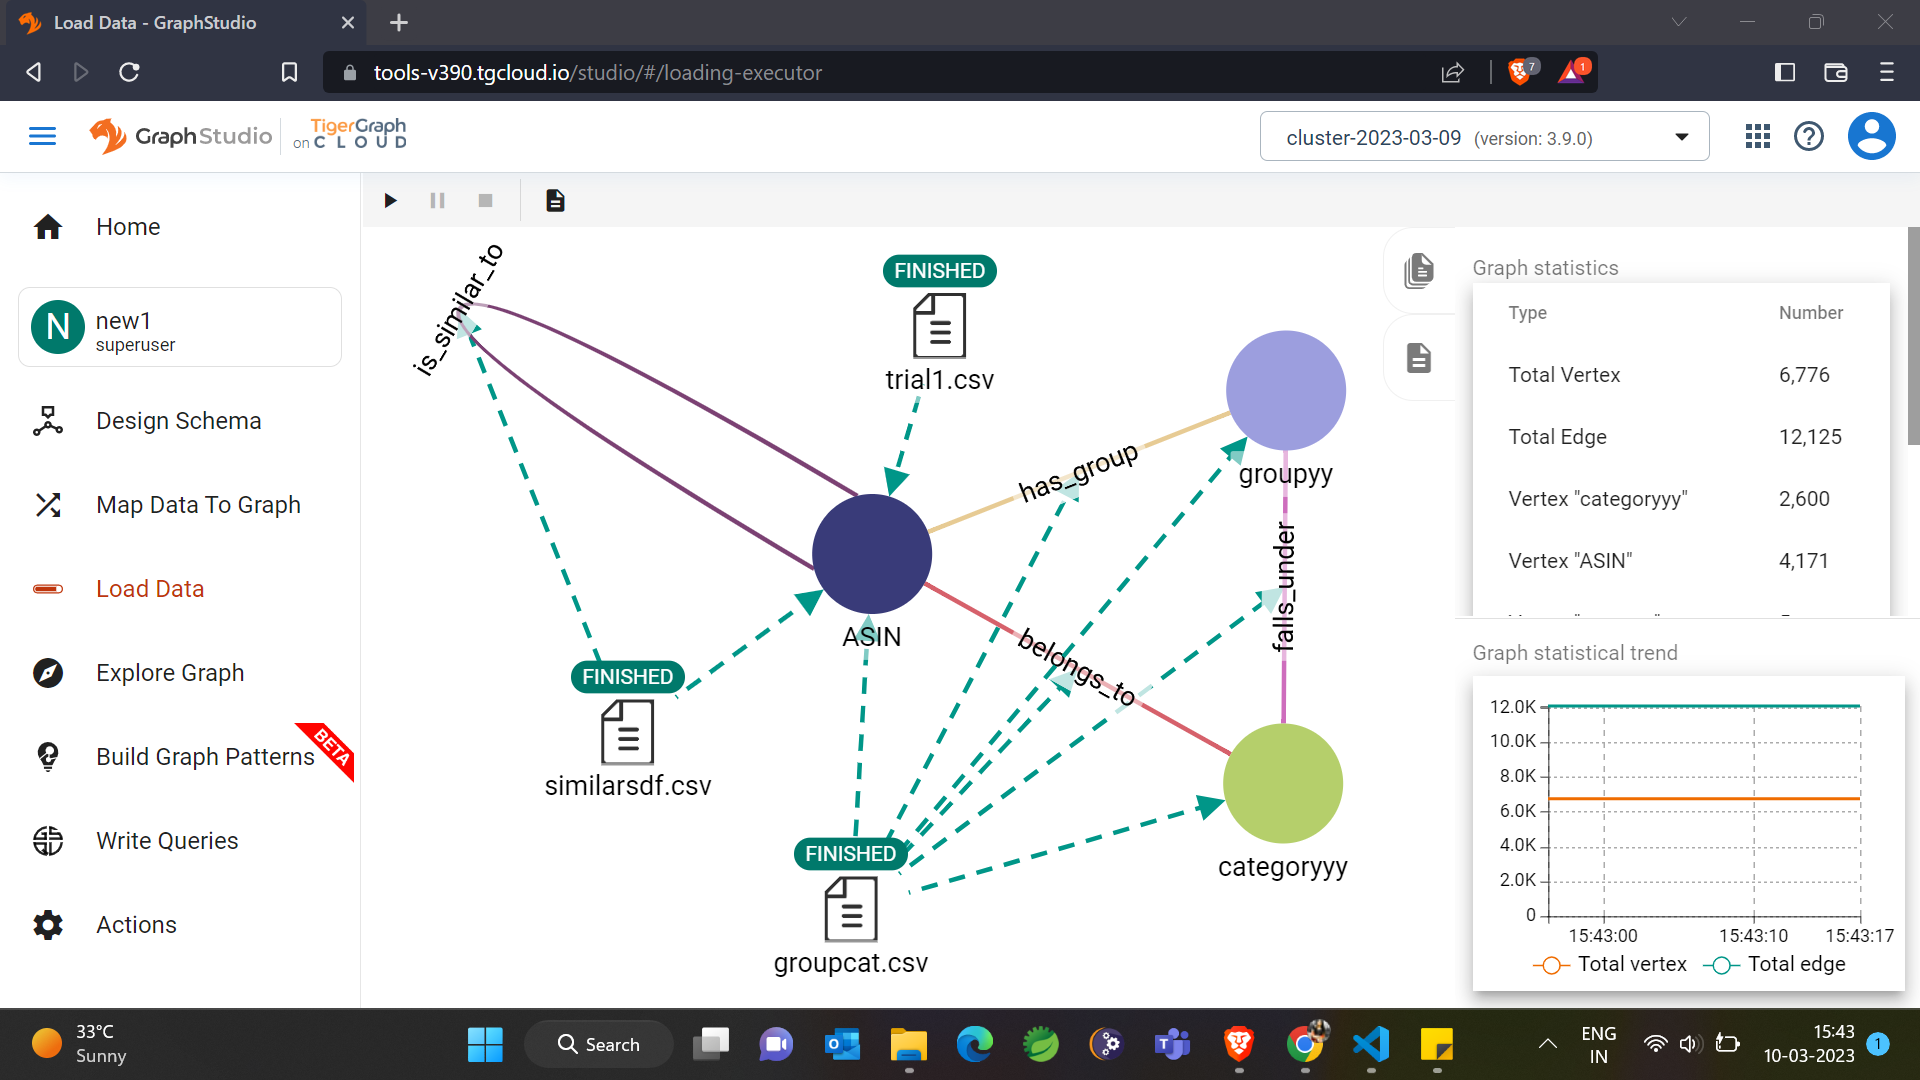

In [54]:
from IPython.display import display
from PIL import Image
path= r"C:\Users\vrushalideshmukh\Pictures\Saved Pictures\schema for amazon.png"
display(Image.open(path))

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

In [56]:
import networkx as nx
# from pyspark.sql.functions import collect_list

# Create an empty graph
G = nx.Graph()

# Convert PySpark dataframe to Pandas dataframe
pandas_df = joined_df.toPandas()

In [65]:
# Add nodes with attributes from Pandas dataframe
for i, row in pandas_df.iterrows():
    if row['asins'] is not None:  # check if asins is not None 
        # Add node 'ASIN' with attributes
        G.add_node(row['asins'], asins=row['asins'], id=row['ID'], titles=row['titles'], groups=row['groups'], salesranks=row['salesranks'], avg_rating=row['avg_rating'], category = row['category'])

        # Add node 'GROUP' with attributes
        G.add_node(row['groups'], groups=row['groups'])

        # Add node 'CATEGORIES' with attributes
        category = row['category']
        for c in category:
            G.add_node(c, category=c)

# Add edges between nodes
for i, row in pandas_df.iterrows():
    # Add edges from 'ASIN' to 'GROUP' and 'CATEGORIES'
    if row['asins'] is not None:
        G.add_edge(row['asins'], row['groups'], label='has_group_edge')
        category = row['category']
        for c in category:
            G.add_edge(row['asins'], category, label='belongs_to_edge')

        # Add edges from 'ASIN' to 'ASIN' and 'CATEGORIES'
        similars = row['similars']
        for s in similars:
            G.add_edge(row['asins'], s, label='is_similar_to_edge')

        to = str(row['to'])
        for t in to:
            G.add_edge(str(row['ID']), str(t), label='co_purchase_edge')

        # Add edges from 'GROUP' to 'CATEGORIES'
        G.add_edge(row['groups'], category, label='falls_under_edge')



In [66]:
nx.write_gml(G, 'Amazon_networkx.gml')

In [73]:
from pyspark.sql.functions import col, collect_list, lit, desc

def getRecomm(inpasin, inpgroup, inpcategory, topN=None):
    if topN is None:
        N = 5
    else:
        N = topN
    
    # Define traversal paths for different inputs
    if inpcategory is not None:
        if inpgroup is not None:
            if inpasin is not None:
                # Traversal through all edges
                df = joined_df.filter(col('category').contains(inpcategory))
                df = df.filter(col('groups')==inpgroup)
                df = df.filter(col('asins')!=inpasin)
            else:
                df = joined_df.filter(col('category').contains(inpcategory))
                df = df.filter(col('groups')==inpgroup)
        else:
            if inpasin is not None:
                df = joined_df.filter(col('category').contains(inpcategory))
                df = df.filter(col('asins')!=inpasin)
            else:
                df = joined_df.filter(col('category').contains(inpcategory))
    else:
        if inpgroup is not None:
            if inpasin is not None:
                df = G.bfs(fromExpr=f"id = '{inpasin}'", toExpr=f"group = '{inpgroup}'", edgeFilter="edge_type = 'co_purchase_edge'")
                df = df.union(joined_df.filter(col('groups')==inpgroup))
                df = df.filter(col('category').contains(inpcategory))
                df = df.filter(col('asins')!=inpasin)
            else:
                df = joined_df.filter(col('groups')==inpgroup)
                df = df.filter(col('category').contains(inpcategory))
        else:
            if inpasin is not None:
                # Traversal through ASIN nodes using co_purchase_edge, has_group_edge, has_category_edge, falls_under_edge, is_similar_to_edge
                df = G.bfs(fromExpr=f"id = '{inpasin}'", edgeFilter="edge_type in ('co_purchase_edge', 'has_group_edge', 'has_category_edge', 'falls_under_edge', 'is_similar_to_edge')")
                # Filter df by group corresponding to the inpasin
                group = joined_df.filter(col('asins')==inpasin).select('groups').collect()[0][0]
                df = df.filter(col('groups')==group)
                df = df.filter(col('category').contains(inpcategory))
                df = df.filter(col('asins')!=inpasin)
            else:
                df = joined_df
                df = df.filter(col('category').contains(inpcategory))
    
    # Calculate scores for all products in the filtered df
    df = df.withColumn('score', ((10000000-col('salesranks'))/10000000 + col('total_reviews')/100 + col('avg_rating'))/3)
    
    df = df.select('asins', 'titles').distinct().sort(asc('score')).limit(N)
    
    return df


In [74]:

rec= getRecomm('1893732290', 'Book', '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Faith[12339]', 10)



+----------+--------------------+
|     asins|              titles|
+----------+--------------------+
|0802848109|Faith and Justifi...|
|0875526500|Faith in the Face...|
|0140275754|The Faith Factor ...|
|0842335935|Soulshaping: Taki...|
+----------+--------------------+

